In [2]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#  setup
client = bigquery.Client()

In [20]:
# pull arbitrum data
query = """
SELECT COUNT(*)
FROM `cs356-480905.arbitrum_vlad_query.arbitrum_attacks`
WHERE (value_usd > 0 AND direction = 'spoof_outgoing')
"""

df = client.query(query).to_dataframe()
df.head()

,f0_
0,496


In [7]:
# find maximum block on arbitrum as this is our "smallest" dataset by timestamp
query_max_ts = """
SELECT MAX(attack_ts) AS latest_attack
FROM `cs356-480905.arbitrum_vlad_query.arbitrum_attacks`
"""

rows = client.query(query_max_ts).result()
max_ts = list(rows)[0].latest_attack
print(max_ts)

2025-06-30 23:59:53+00:00


In [60]:
# find minimum block on arbitrum as this is our "smallest" dataset by timestamp
query_min_ts = """
SELECT MIN(attack_ts) AS latest_attack
FROM `cs356-480905.arbitrum_vlad_query.arbitrum_attacks`
"""

rows = client.query(query_min_ts).result()
min_ts = list(rows)[0].latest_attack
print(min_ts)

2024-01-12 20:25:50+00:00


In [34]:
# find maximum block on arbitrum as this is our "smallest" dataset by timestamp
query = """
SELECT MAX(attack_ts) AS latest_attack
FROM `cs356-480905.arbitrum_vlad_query.arbitrum_attacks`
"""

rows = client.query(query).result()
row = list(rows)[0]   # Convert RowIterator → first row
print(row.latest_attack)

2025-06-30 23:59:53+00:00


In [11]:
# pull optimism data from feb 1 2024 to identified maximum 
query_optimism = f"""
SELECT COUNT(*) AS optimism_count
FROM `cs356-478822.optimism_vlad_query.optimism_attacks`
WHERE attack_ts BETWEEN TIMESTAMP("2024-02-01") AND TIMESTAMP("{max_ts}") AND
attack_type = 'tiny_transfer'
"""

optimism_df = client.query(query_optimism).to_dataframe()
optimism_df.head()

,optimism_count
0,246738


In [14]:
# pull ethereum data
query_ethereum = f"""
SELECT COUNT(*) AS ethereum_count
FROM `cs356-478822.eth_vlad_query.vald_query_attacks`
WHERE attack_ts BETWEEN TIMESTAMP("2024-04-01") AND TIMESTAMP("{max_ts}") AND
attack_type = 'zero_value'
"""

ethereum_df = client.query(query_ethereum).to_dataframe()
ethereum_df.head()

,ethereum_count
0,5989861


In [9]:
# pull arbitrum data
query_arbitrum = f"""
SELECT COUNT(*) AS arbitrum_count
FROM `cs356-480905.arbitrum_vlad_query.arbitrum_attacks`
WHERE attack_ts BETWEEN TIMESTAMP("2024-02-01") AND TIMESTAMP("{max_ts}") AND
attack_type = 'tiny_transfer'
"""

arbitrum_df = client.query(query_arbitrum).to_dataframe()
arbitrum_df.head()

,arbitrum_count
0,1131971


### Begin per month analysis

In [72]:
# pull arbitrum per month 
query_arbitrum_per_month = f"""
SELECT
  FORMAT_TIMESTAMP("%Y-%m", attack_ts) AS month,
  COUNT(*) AS arbitrum_count
FROM `cs356-480905.arbitrum_vlad_query.arbitrum_attacks`
WHERE attack_ts BETWEEN TIMESTAMP("2024-07-01") AND TIMESTAMP("{max_ts}")
GROUP BY month
ORDER BY month
"""
arbitrum_df_per_month = client.query(query_arbitrum_per_month).to_dataframe()

# pull optimism per month
query_optimism_per_month = f"""
SELECT
  FORMAT_TIMESTAMP("%Y-%m", attack_ts) AS month,
  COUNT(*) AS optimism_count
FROM `cs356-478822.optimism_vlad_query.optimism_attacks`
WHERE attack_ts BETWEEN TIMESTAMP("2024-07-01") AND TIMESTAMP("{max_ts}")
GROUP BY month
ORDER BY month
"""
optimism_df_per_month = client.query(query_optimism_per_month).to_dataframe()

# pull ethereum per month
query_ethereum_per_month = f"""
SELECT
  FORMAT_TIMESTAMP("%Y-%m", attack_ts) AS month,
  COUNT(*) AS ethereum_count
FROM `cs356-478822.eth_vlad_query.vald_query_attacks`
WHERE attack_ts BETWEEN TIMESTAMP("2024-07-01") AND TIMESTAMP("{max_ts}")
GROUP BY month
ORDER BY month
"""
ethereum_df_per_month = client.query(query_ethereum_per_month).to_dataframe()


In [73]:
arbitrum_df_per_month.head()

,month,arbitrum_count
0,2024-07,351438
1,2024-08,253984
2,2024-09,424573
3,2024-10,367899
4,2024-11,210679


In [74]:
optimism_df_per_month.head()

,month,optimism_count
0,2024-07,55789
1,2024-08,72186
2,2024-09,97260
3,2024-10,111828
4,2024-11,224704


In [75]:
ethereum_df_per_month.head()

,month,ethereum_count
0,2024-07,131263
1,2024-08,249574
2,2024-09,177770
3,2024-10,2556035
4,2024-11,1562918


In [77]:
# Merge on 'month'
df = arbitrum_df_per_month.merge(optimism_df_per_month, on='month', how='outer')
df = df.merge(ethereum_df_per_month, on='month', how='outer')

# Fill missing months with 0
df = df.fillna(0)

# Optional: sort by month (just in case)
df = df.sort_values('month')

df.head()


,month,arbitrum_count,optimism_count,ethereum_count
0,2024-07,351438,55789,131263
1,2024-08,253984,72186,249574
2,2024-09,424573,97260,177770
3,2024-10,367899,111828,2556035
4,2024-11,210679,224704,1562918


### Create charts

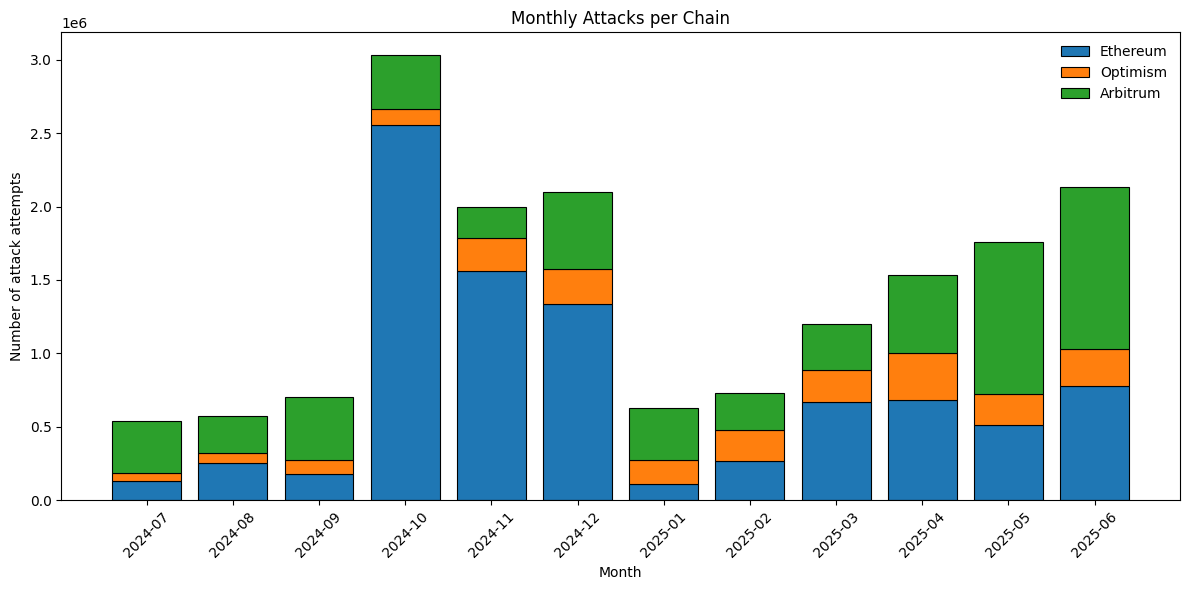

In [84]:
import matplotlib.pyplot as plt

# Define professional colors (muted and colorblind-friendly)
colors = {
    'Ethereum': '#1f77b4',   # muted blue
    'Optimism': '#ff7f0e',   # muted orange
    'Arbitrum': '#2ca02c',   # muted green
}

months = df['month']

plt.figure(figsize=(12,6))

# Add edgecolor='black' and linewidth=0.8 for subtle borders
plt.bar(months, df['ethereum_count'], label='Ethereum', color=colors['Ethereum'], edgecolor='black', linewidth=0.8)
plt.bar(months, df['optimism_count'], bottom=df['ethereum_count'], label='Optimism', color=colors['Optimism'], edgecolor='black', linewidth=0.8)
plt.bar(months, df['arbitrum_count'], bottom=df['ethereum_count'] + df['optimism_count'], label='Arbitrum', color=colors['Arbitrum'], edgecolor='black', linewidth=0.8)

plt.xticks(rotation=45)
plt.ylabel("Number of attack attempts")
plt.xlabel("Month")
plt.title("Monthly Attacks per Chain")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined